In [44]:
import numpy as np
import pandas as pd
import glob
import os
from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import emoji

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec


In [45]:
df = pd.read_csv('./dataset/Tweets/tweets-sentiment-roberta.csv')

In [46]:
def get_df_info(df):
    print('Dataframe shape: ', df.shape)
    print('-----'*20)
    print('Dataframe info: ')
    print(df.info())
    print('-----'*20)
    print('Dataframe null values count:')
    print(df.isna().sum())
    print('-----'*20)
    print('Dataframe duplicates count:')
    print(df.duplicated().sum())
    print('-----'*20)
    print('Dataframe sample: ')
    display(df.sample(10))

In [47]:
get_df_info(df)

Dataframe shape:  (249025, 5)
----------------------------------------------------------------------------------------------------
Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249025 entries, 0 to 249024
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   stock    249025 non-null  object 
 1   date     249025 non-null  object 
 2   tweets   249025 non-null  object 
 3   bearish  249025 non-null  float64
 4   bullish  249025 non-null  float64
dtypes: float64(2), object(3)
memory usage: 9.5+ MB
None
----------------------------------------------------------------------------------------------------
Dataframe null values count:
stock      0
date       0
tweets     0
bearish    0
bullish    0
dtype: int64
----------------------------------------------------------------------------------------------------
Dataframe duplicates count:
0
-------------------------------------------------------------------------

,stock,date,tweets,bearish,bullish
21962,AMT,2019-10-16,$AMT could put in a minor top<221.57 pic.twit...,0.054836,0.945164
234692,TSLA,2019-11-08,"Congrats Mr Tesla, you made the team 🎉 \n\nWas...",0.041566,0.958434
204349,NFLX,2020-03-23,$FTR OVERSOLD! Bouncing AFTERHOURS💸📈✈ $AMW $CR...,0.001386,0.998615
17624,AAPL,2020-05-13,the #Markets have likely entered summer tradin...,0.995686,0.004314
203055,NFLX,2020-03-01,$NFLX wow. I actually see a potential rise thi...,0.015147,0.984854
199973,NFLX,2020-01-08,$NFLX: The Windsors Season 1 👑,0.630230,0.369770
32741,AMZN,2019-11-21,"$AMZN so called ""Heavy calls"" OI; those are op...",0.004834,0.995166
166087,LUV,2020-05-16,$DAL $UAL $LUV $AAL\n05.15.20 total traveler t...,0.189145,0.810855
67351,C,2020-03-15,OmFG!! $SPY $SPX $QQQ $IWM $DJI $AAPL $TSLA $F...,0.167925,0.832075
165074,LUV,2020-04-28,Southwest Hunkers Down For More financial Loss...,0.630525,0.369474


In [48]:
df['sentiment'] = df[['bearish', 'bullish']].idxmax(axis = 1)
df.head()

,stock,date,tweets,bearish,bullish,sentiment
0,AAPL,2019-07-15,Top 5 Apple Prime Day deals http://dlvr.it/R8...,0.001388,0.998612,bullish
1,AAPL,2019-07-15,CCI Buy Signals : $AAPL $GDXJ $GH $ZS $JNUG,0.001409,0.998591,bullish
2,AAPL,2019-07-15,Traders checkout these trade plans given over ...,0.001429,0.998571,bullish
3,AAPL,2019-07-15,272 stocks \nMoved Above Upper Price Channel...,0.001382,0.998618,bullish
4,AAPL,2019-07-15,Watch what happened at 3:23 in @NaviAvatar1's ...,0.001471,0.998529,bullish


In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibrahim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
# Reusable model function
def fit_train_predict_model(X_train, y_train, X_test, y_test):
    models = [
        LogisticRegression(C = 2, solver='liblinear', max_iter=1000),
        RandomForestClassifier()
        # DecisionTreeClassifier(),
        # MultinomialNB(),
        # SGDClassifier(max_iter=100),
        # LinearSVC(C = 2, max_iter=500)
    ]
    for model in models:
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        print('======='*10)
        print(type(model).__name__)
        print('======='*10)
        print(classification_report(y_test, y_pred_test))
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)
        plt.show()
    
    return models

In [51]:
class Preprocessor:
    def __init__(
        self, 
        stopwords=stopwords.words('english'), 
        vectorizer = CountVectorizer(max_features=30000, ngram_range=(1,3))
    ):
        self.stopwords = stopwords
        self.vectorizer = vectorizer
        self.vectorizer_fitted = False
        self.wnl = WordNetLemmatizer()
        self.usernam_pattern = re.compile(r'(\@)(\S+)')
        self.twitter_handle_pattern = re.compile(r'(\#)(\S+)')
    
    def clean_tweet(self, texts):
        print('Cleaning...')
        cleaned_texts = []
        for text in texts:
            # Replace @usernames with the text mention_
            text = re.sub(self.usernam_pattern, r'mention_\2', text)
            # Replace #hashtags with the text hashtag_
            text = re.sub(self.twitter_handle_pattern, r'hashtag_\2', text)
            # remove URLs
            text = re.sub(r'https?://\S+', "", text)
            text = re.sub(r'www.\S+', "", text)
            # remove $cashtags
            text = re.sub(r'(\$)([A-Za-z]+)', r'cashtag_\2', text)
            # remove extra spaces
            text = re.sub(r' +', '', text)
            # deemojize
            text = emoji.demojize(text, delimiters=("", " "))
            text = text.strip()
            cleaned_texts.append(text)

        return cleaned_texts
    
    def tokenize(self, texts):
        return [word_tokenize(text) for text in texts]

    def lemmatize(self, texts):
        print('Lemmatizing...')
        tokens_list = self.tokenize(texts)
        return [' '.join([self.wnl.lemmatize(token) for token in text]) for text in tokens_list]

    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        # print('Removing Nans...')
        # X = X[~X.isnull()]                          # delete nans
        # X = X[~X.duplicated()]                      # delete duplicates
        
        # X = self.remove_stopwords(X)                 # remove stopwords
        X = self.clean_tweet(X)
        X = self.lemmatize(X)                        # lemmatize
        
        if (mode == 'train'):
            # self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X)             # vectorize
        
        return X

### Train test split

In [52]:
(X_train, X_test, y_train, y_test) = train_test_split(df['tweets'], df['sentiment'], test_size=0.2)

### Preprocess using CountVectorizer (Bag of words)

In [53]:
X_cv_train = X_train.copy()
X_cv_test = X_test.copy()

In [54]:
cv_preprocessor = Preprocessor() # Default vectorizer is the CountVectorizer

X_cv_train = cv_preprocessor.transform(X_cv_train)
X_cv_test = cv_preprocessor.transform(X_cv_test, mode='test')

Cleaning...
Lemmatizing...
Fitting vectorizer...
Vectorizing...
Cleaning...
Lemmatizing...
Vectorizing...


In [55]:
print(X_cv_train.shape)
print(y_train.shape)

(199220, 30000)
(199220,)


LogisticRegression
              precision    recall  f1-score   support

     bearish       0.77      0.24      0.36     11792
     bullish       0.81      0.98      0.88     38013

    accuracy                           0.80     49805
   macro avg       0.79      0.61      0.62     49805
weighted avg       0.80      0.80      0.76     49805



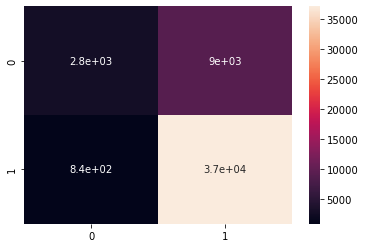

RandomForestClassifier
              precision    recall  f1-score   support

     bearish       0.71      0.31      0.43     11792
     bullish       0.82      0.96      0.88     38013

    accuracy                           0.81     49805
   macro avg       0.76      0.63      0.66     49805
weighted avg       0.79      0.81      0.78     49805



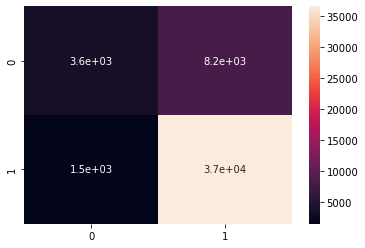

[LogisticRegression(C=2, max_iter=1000, solver='liblinear'),
 RandomForestClassifier()]

In [56]:
fit_train_predict_model(X_cv_train, y_train, X_cv_test, y_test)

### Vectorize the text feature using Tfidf Vectorizer

In [57]:
X_tfidf_train = X_train.copy()
X_tfidf_test = X_test.copy()

In [58]:
tfidf_preprocessor = Preprocessor(vectorizer=TfidfVectorizer(lowercase=False, max_features=30000, min_df=10, ngram_range=(1, 3)))

X_tfidf_train = tfidf_preprocessor.transform(X_tfidf_train)
X_tfidf_test = tfidf_preprocessor.transform(X_tfidf_test, mode='test')


Cleaning...
Lemmatizing...
Fitting vectorizer...
Vectorizing...
Cleaning...
Lemmatizing...
Vectorizing...


LogisticRegression
              precision    recall  f1-score   support

     bearish       0.79      0.20      0.31     11792
     bullish       0.80      0.98      0.88     38013

    accuracy                           0.80     49805
   macro avg       0.79      0.59      0.60     49805
weighted avg       0.80      0.80      0.75     49805



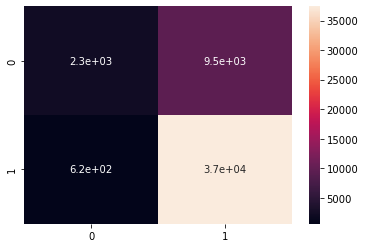

RandomForestClassifier
              precision    recall  f1-score   support

     bearish       0.75      0.26      0.39     11792
     bullish       0.81      0.97      0.88     38013

    accuracy                           0.80     49805
   macro avg       0.78      0.62      0.64     49805
weighted avg       0.80      0.80      0.77     49805



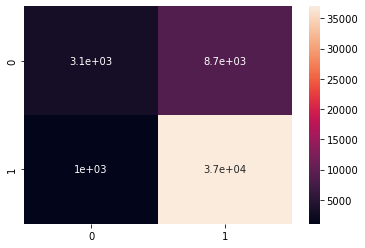

[LogisticRegression(C=2, max_iter=1000, solver='liblinear'),
 RandomForestClassifier()]

In [59]:
fit_train_predict_model(X_tfidf_train, y_train, X_tfidf_test, y_test)

### Word2Vec vectorization

In [60]:
class Word2Vectorizer():
    def __init__(self):
        self.model = None
        self.vector_size = 1000

    def fit(self, X):
        tweet_list = [word_tokenize(tweet) for tweet in X]
        model = Word2Vec(tweet_list, min_count = 1, window = 3, sg = 1, workers = 8, max_vocab_size = 40000, vector_size=self.vector_size)
        self.model = model
        print(len(model.wv))
    
    #Build word vector for training set by using the average value of all word vectors in the tweet, then scale
    def __buildWordVector(self, text, size):
        vec = np.zeros(size)
        count = 0.
        for word in text:
            try:
                vec += self.model.wv[word]
                count += 1.
            except KeyError:
                continue
        if count != 0:
            vec /= count
        return vec

    def transform(self, X):
        # self.model = gensim.models.Word2Vec.load('tweets.embedding')
        tweet_list = [word_tokenize(tweet) for tweet in X]
        return [self.__buildWordVector(tweet, self.vector_size) for tweet in tweet_list]
         

In [64]:
X_w2v_train = X_train.copy()
X_w2v_test = X_test.copy()

In [65]:
w2vectorizer = Word2Vectorizer()

w2v_preprocessor = Preprocessor(vectorizer=w2vectorizer) # Default vectorizer is the CountVectorizer

w2v_preprocessor.transform(df['tweets'])
train_w2v_vectorized_text = w2v_preprocessor.transform(X_w2v_train, mode = 'test')
test_w2v_vectorized_text = w2v_preprocessor.transform(X_w2v_test, mode='test')

Cleaning...
Lemmatizing...
Fitting vectorizer...
21026
Vectorizing...
Cleaning...
Lemmatizing...
Vectorizing...
Cleaning...
Lemmatizing...
Vectorizing...


LogisticRegression
              precision    recall  f1-score   support

     bearish       0.67      0.05      0.09     11792
     bullish       0.77      0.99      0.87     38013

    accuracy                           0.77     49805
   macro avg       0.72      0.52      0.48     49805
weighted avg       0.75      0.77      0.68     49805



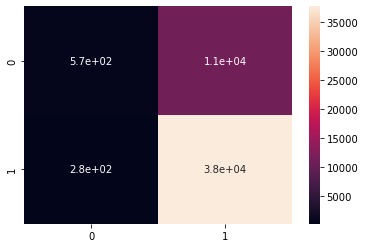

RandomForestClassifier
              precision    recall  f1-score   support

     bearish       0.73      0.21      0.32     11792
     bullish       0.80      0.98      0.88     38013

    accuracy                           0.79     49805
   macro avg       0.76      0.59      0.60     49805
weighted avg       0.78      0.79      0.75     49805



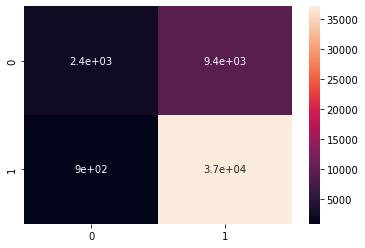

[LogisticRegression(C=2, max_iter=1000, solver='liblinear'),
 RandomForestClassifier()]

In [66]:
fit_train_predict_model(train_w2v_vectorized_text, y_train, test_w2v_vectorized_text, y_test)